# Model Classes

In [3]:
from collections import namedtuple
from typing import Iterable
import random

DiceFace = namedtuple("DiceFace", ["gear", "movement"])

class Dice():
    def __init__(self, gears: Iterable[int], movements: Iterable[int]):
        if not len(gears) == len(movements):
            raise UserWarning("gears and movements must have the same length") 
        self.faces = [DiceFace(gear, movement)
                         for (gear, movement) in zip(gears, movements)]

    def roll(self) -> DiceFace:
        return random.choice(self.faces)

    def gears(self) -> Iterable[int]:
        return [face.gear for face in self.faces]

    def movements(self) -> Iterable[int]:
        return [face.movement for face in self.faces]      

class GhostCar():
    def __init__(self, white_dice, black_dice):
        self.white_dice = white_dice
        self.black_dice = black_dice

    def gears(self):
        return self.white_dice.gears() + self.black_dice.gears()

    def movements(self):
        return self.white_dice.movements() + self.black_dice.movements()

    def race(self, turns=10):
        return [self.black_dice.roll() if turn % 2 == 0 else self.white_dice.roll()
                 for turn in range(turns)]


# Driverless Cars classes

In [4]:
from itertools import product

HAZARD = 0 # do not move
BLANK = 1  # move 1 space
red_dice =   [HAZARD, HAZARD, BLANK, BLANK, BLANK, BLANK] 
white_dice = [HAZARD, BLANK, BLANK, BLANK, BLANK, BLANK] 

class DriverlessCar():
    def __init__(self, constant, white_dice_number, red_dice_number):
        self.constant = constant
        self.white_dice_number = white_dice_number
        self.red_dice_number = red_dice_number
    
    def movements(self):
        dice = [white_dice for _ in range(self.white_dice_number)] + [red_dice for _ in range(self.red_dice_number)]
        return [sum((self.constant, *dice_values)) for dice_values in product(*dice)]


In [5]:
dc_champion = DriverlessCar(constant=3, white_dice_number=2, red_dice_number=2)
dc_veteran = DriverlessCar(constant=3, white_dice_number=2, red_dice_number=1)
dc_midfielder = DriverlessCar(constant=3, white_dice_number=1, red_dice_number=2)
dc_silver = DriverlessCar(constant=3, white_dice_number=2, red_dice_number=0)
dc_rookie = DriverlessCar(constant=3, white_dice_number=1, red_dice_number=1)
dc_amateur = DriverlessCar(constant=3, white_dice_number=0, red_dice_number=2)

# Plots

In [6]:
from collections import Counter
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import Span, Range1d, Label
from bokeh.plotting import figure
from bokeh.layouts import row, column, grid
from statistics import mean

output_notebook()

MOVEMENT_RANGE = (2.3, 8.7)
GEARS_RANGE = (0.3, 6.7)
WIDTH = 300
HEIGHT = 300
THIN = 100

def plot_occurences(data: Iterable[int], label: str=None, color: str="deepskyblue", orientation: str="horizontal", range=None):
    count = Counter(data)
    
    if orientation == "vertical":
        plot = figure(plot_width=THIN, plot_height=300,
            min_border=0, toolbar_location=None)        
        plot.hbar(y=list(count.keys()), right=list(count.values()), height=1, fill_color=color, line_color="black")
        average = Span(location=mean(data),
                        dimension="width", line_color="black",
                        line_dash="dashed", line_width=3)  
        average_label = Label(x=10, y=1.03*mean(data), x_units="screen", text=f"{mean(data):.2f}")
        plot.yaxis.axis_label = label
        plot.xaxis.axis_label = "occurences"
        if range:
            plot.y_range=Range1d(*range)
    else:
        plot = figure(plot_width=WIDTH, plot_height=THIN,
            min_border=0, toolbar_location=None)
        plot.vbar(x=list(count.keys()), top=list(count.values()), width=1, fill_color=color, line_color="black")
        average = Span(location=mean(data),
                                dimension="height", line_color="black",
                                line_dash="dashed", line_width=3)  
        average_label = Label(x=1.03*mean(data), y=10, y_units="screen", text=f"{mean(data):.2f}")
        plot.xaxis.axis_label = label
        plot.yaxis.axis_label = "occurences"
        if range:
            plot.x_range=Range1d(*range)

    plot.add_layout(average)
    plot.add_layout(average_label)
    return plot

def plot_gear_wrt_movement(dice_or_gc, label: str=None, color: str="deepskyblue"):
    gears = dice_or_gc.gears()
    movements = dice_or_gc.movements()
    plot = figure(title=f"{label}", plot_width=WIDTH, plot_height=HEIGHT,
        min_border=0, toolbar_location=None)
    plot.square(x=movements, y=gears, fill_color=color, line_color="black", size=20)
    
    average_movement = Span(location=mean(movements),
                              dimension="height", line_color="black",
                              line_dash="dashed", line_width=3)
    plot.add_layout(average_movement)
    plot.add_layout(Label(x=1.03*mean(movements), y=10, y_units="screen", text=f"{mean(movements):.2f}"))

    average_gear = Span(location=mean(gears),
                              dimension="width", line_color="black",
                              line_dash="dashed", line_width=3)
    plot.add_layout(average_gear)
    plot.add_layout(Label(x=10, y=1.03*mean(gears), x_units="screen", text=f"{mean(gears):.2f}"))

    plot.xaxis.axis_label = "movement"
    plot.x_range=Range1d(*MOVEMENT_RANGE)
    plot.yaxis.axis_label = "gears"
    plot.y_range=Range1d(*GEARS_RANGE)
    return plot



Loading BokehJS ...

In [7]:
def plot_movement_gears_layout(dice_or_gc, label: str=None, color: str="deepskyblue"):
    return grid([
                    [plot_gear_wrt_movement(dice_or_gc, label, color),
                     plot_occurences(dice_or_gc.gears(), range=GEARS_RANGE, color=color,orientation="vertical")],
                    [plot_occurences(dice_or_gc.movements(),range=MOVEMENT_RANGE, color=color),
                     None]
                ])


def plot_ghost_car_statistics(ghost_car: GhostCar):
    return row([plot_movement_gears_layout(ghost_car, "ghost car"),
                 plot_movement_gears_layout(ghost_car.white_dice, "white dice", color="lightgray"),
                 plot_movement_gears_layout(ghost_car.black_dice, "black dice", color="dimgray")])           



# Dice faces images

In [8]:
from PIL import Image, ImageOps
import os
IMG = "img"
IMG_HEIGHT = 167
IMG_WIDTH = 167


def dice_face_image(dice_color: str, car_color: str, gear: int, movement: int) -> Image:
    marker = Image.open(os.path.join(IMG, f"{dice_color}_{car_color}.png"))
    gear_image = Image.open(os.path.join(IMG, f"gear{gear}.png"))
    movement_image = Image.open(os.path.join(IMG, f"movement{movement}.png"))

    dice_face = Image.new("RGBA", (IMG_WIDTH, IMG_HEIGHT))
    dice_face.alpha_composite(marker)
    if dice_color is "black":
        gear_image = RGBAInvert(gear_image)
    dice_face.alpha_composite(gear_image)
    dice_face.alpha_composite(movement_image)
    return dice_face

def RGBAInvert(img) :
    inverted_color_bands = [ImageOps.invert(b) for b in img.split()[:3]]
    alpha = img.split()[3]
    return Image.merge(img.mode,  inverted_color_bands + [alpha])

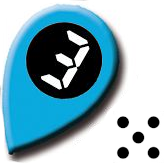

In [9]:
dice_face_image("black", "blue", gear=3, movement=5)

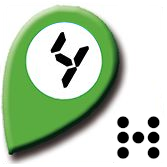

In [10]:
dice_face_image("white", "green", gear=4, movement=7)

In [11]:
def ghost_car_image(white_dice: Dice, black_dice: Dice, car_color: str) -> Image:
    # TODO based on dice_image
    return None

def dice_image(dice: Dice, dice_color: str, car_color: str) -> Image:
    return concat_images([dice_face_image(dice_color, car_color, face.gear, face.movement)
                 for face in dice.faces])
    
    

def concat_images(images, direction="horizontal") -> Image:
    width, height = images[0].size # Assuming all images have the same size
    result_size = (width * len(images), height) if direction is "horizontal" else (width, height * len(images))
    result = Image.new("RGBA", result_size)
    for index, image in enumerate(images):
        result.paste(image, (index*width, 0)) if direction is "horizontal" else result.paste(image, (0, index*height))
    return result


# PDF generation

In [20]:
from fpdf import FPDF
from os.path import splitext

def generate_pdf(image_path : str):
    pdf = FPDF()
    pdf.add_page()
    pdf.image(image_path, x=10, y=8, w=100)
    pdf.output(f"{splitext(image_path)[0]}.pdf")
    return pdf

In [21]:
dice_face_image("white", "green", gear=4, movement=7).save("test.png")
generate_pdf("test.png")